In [2]:
import jax
import jax.numpy as jnp
import jax.scipy as jsc
import matplotlib.pyplot as plt
import numpy as np
import pyhf
from celluloid import Camera
from model import hepdata_like

jax.config.update("jax_enable_x64", True)

In [3]:
def yields(x):
    s = 15 + x
    b = 45 - 2 * x
    db = 1 + 0.2 * x**2
    return jnp.asarray([s]), jnp.asarray([b]), jnp.asarray([db])

In [4]:
def model_maker(get_yields):
    def make_model(x):
        s, b, db = get_yields(x)
        m = hepdata_like(s, b, db)
        nompars = m.config.suggested_init()
        bonlypars = jnp.asarray([x for x in nompars])
        bonlypars = jax.ops.index_update(bonlypars, m.config.poi_index, 0.0)
        return m, bonlypars

    return make_model

In [5]:
x = model_maker(yields)
x(3)

(<model.Model at 0x7faffb91deb0>, DeviceArray([0., 1.], dtype=float64))

In [6]:
from infer import expected_CLs

cls = expected_CLs(model_maker=model_maker(yields))


def get_cls(config):
    return cls(config, 1.0)[0]

In [7]:
jax.grad(get_cls)(2.0)

DeviceArray(-0.00662794, dtype=float64)

In [8]:
xx = jnp.linspace(0, 10)

cls_values = jax.vmap(get_cls)(xx)

Text(0, 0.5, '$CL_s$')

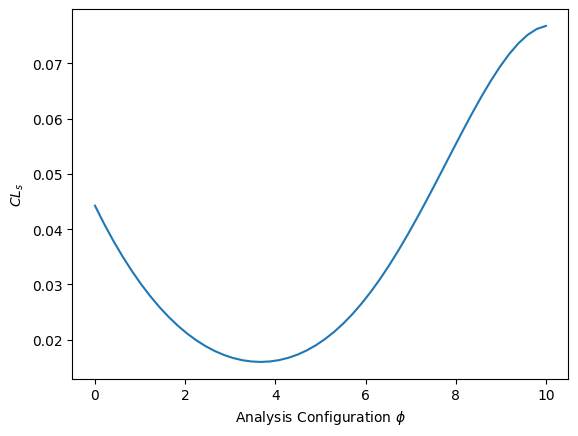

In [9]:
plt.plot(xx, cls_values)
plt.xlabel(r"Analysis Configuration $\phi$")
plt.ylabel(r"$CL_s$")

0.04101060990368399 0.5117147103795601
0.03643014230282837 0.7881930274096942
0.03281309358008433 1.0352743710212389
0.029916608855789173 1.2572763165288037
0.027573531786093675 1.4575693289440552
0.025663165400043875 1.638883068293079
0.02409552342182364 1.8034821687143943
0.022802041921661687 1.9532754368164569
0.02172966807703469 2.089889261414201
0.020836869585825424 2.2147204942326364
0.020090823583152728 2.328976607344235
0.019465377482253077 2.4337073034109067
0.018939539810430617 2.5298299608255745
0.018496347397124246 2.618150385005268
0.018122005990072854 2.699379859651351
0.017805232619178657 2.7741492205051332
0.017536748468563124 2.843020504552916
0.017308884990771656 2.9064966169631696
0.01711527582175343 2.9650293727387687
0.01695061413286525 3.0190262049114804
0.0168104602039032 3.068855780325264
0.016691087779239666 3.1148527173372886
0.016589360576067635 3.1573215691418968
0.016502632379454152 3.1965402015366426
0.01642866572386592 3.232762674840157
0.0163655653114820

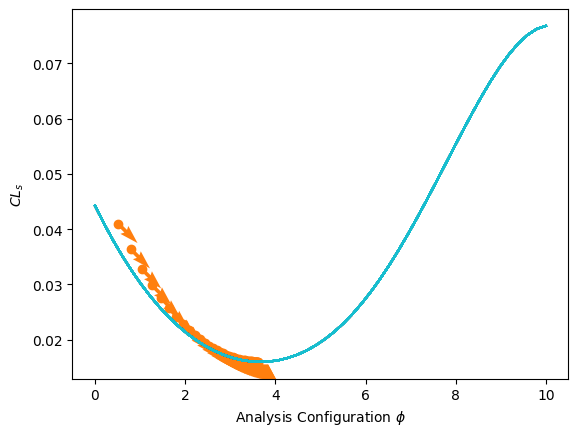

In [10]:
# training
x_init = 0.2


def grad_descent(current_x, lr=2):
    current_cls, grad = jax.value_and_grad(get_cls)(current_x)
    x = current_x - grad * lr
    return x, current_x, current_cls, grad


x = x_init

fig, ax = plt.subplots()
ax.plot(xx, cls_values)
ax.set_xlabel(r"Analysis Configuration $\phi$")
ax.set_ylabel(r"$CL_s$")
camera = Camera(fig)

for i in range(50):
    x, current_x, loss, grad = grad_descent(x, lr=20)
    print(loss, current_x)
    ax.plot(xx, cls_values, color="C9")
    ax.set_xlabel(r"Analysis Configuration $\phi$")
    ax.set_ylabel(r"$CL_s$")
    plt.scatter(current_x, loss, color="C1")
    plt.quiver(current_x, loss, -grad, grad, color="C1")
    camera.snap()

In [11]:
animation = camera.animate()
animation.save("animation2.gif", writer="imagemagick", fps=10)

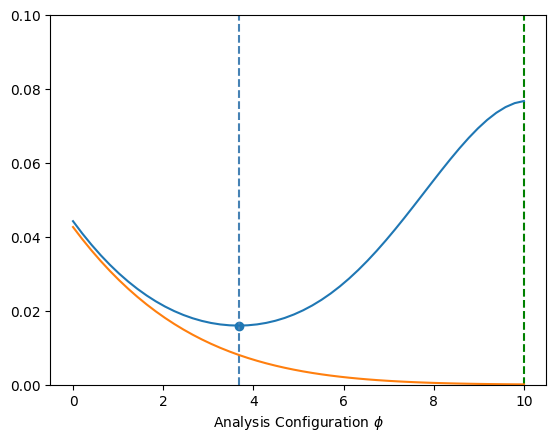

Text(0.5, 0, 'Analysis Configuration $\\phi$')

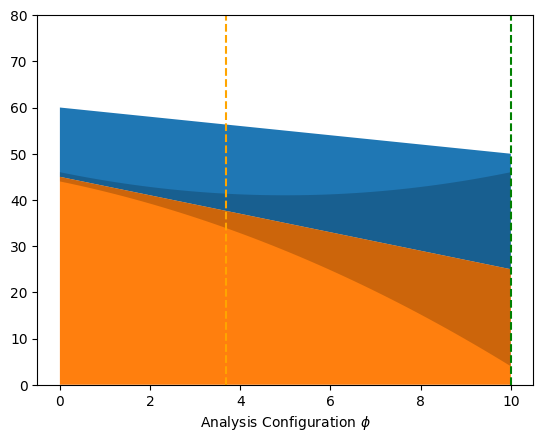

In [2]:
x = np.linspace(0, 10)
s = 15 + x
b = 45 - 2 * x
db = 1 + 0.2 * x**2


def get_cls(s, b, db):
    model = pyhf.simplemodels.hepdata_like([s], [b], [db])
    data = [b] + model.config.auxdata
    cls_val = pyhf.infer.hypotest(1.0, data, model)
    return cls_val


cls_v = [get_cls(s, b, db) for s, b, db in np.stack([s, b, db]).T]
plt.scatter(x[np.argmin(cls_v)], cls_v[np.argmin(cls_v)])
plt.vlines(x[np.argmin(cls_v)], 0, 0.1, colors="steelblue", linestyles="dashed")
plt.plot(x, cls_v, label="CLs w/ syst.")
cls_v_nosyst = [get_cls(s, b, 0.01) for s, b, db in np.stack([s, b, db]).T]
plt.plot(x, cls_v_nosyst, label="CLs no syst.")
plt.vlines(x[np.argmin(cls_v_nosyst)], 0, 0.1, colors="green", linestyles="dashed")
plt.xlabel(r"Analysis Configuration $\phi$")
plt.ylim(0, 0.1)

plt.show()

plt.fill_between(x, s + b, b)
plt.fill_between(x, b)
plt.fill_between(x, b - db, b + db, facecolor="k", alpha=0.2)
plt.vlines(x[np.argmin(cls_v)], 0, 80, colors="orange", linestyles="dashed")
plt.vlines(x[np.argmin(cls_v_nosyst)], 0, 80, colors="green", linestyles="dashed")
plt.ylim(0, 80)
plt.xlabel(r"Analysis Configuration $\phi$")